# Demo for nonlinear inverse design of kirigami patterns

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *
import scipy.optimize as scopt
import time

## Define an objective function based on circularity

In [5]:
def boundary_residual_circle(interior_offsets_vector):
    """
    Objective function for optimizing kirigami pattern to achieve circular boundary contraction.
    
    This function evaluates how well the contracted kirigami pattern approximates a circle
    by measuring deviations from uniform radial distances to the boundary center.
    
    Parameters
    ----------
    interior_offsets_vector : np.ndarray, shape (width*height,)
        Flattened array of interior offset parameters for the kirigami pattern.
        Will be reshaped to (height, width) for the linear inverse design.
    
    Returns
    -------
    residuals : np.ndarray, shape (len(reduced_dual_bound_inds),)
        Residual errors representing deviations from perfect circularity.
        Each element is (distance_from_center - mean_distance) for a boundary point.
        A perfect circle would give zero residuals.
    
    Global Variables Used
    ---------------------
    width : int
        Number of linkage columns in the kirigami pattern (8)
    height : int  
        Number of linkage rows in the kirigami pattern (8)
    structure : MatrixStructure
        Kirigami structure object for layout computation
    boundary_points_vector : np.ndarray, shape (N, 2)
        Concatenated boundary point coordinates
    corners : np.ndarray, shape (4, 2)
        Corner coordinates of the structure
    boundary_offsets : list of lists
        Boundary offset parameters for each edge
    reduced_dual_bound_inds : list, length 36
        Indices of dual boundary nodes used for circularity assessment
        
    Notes
    -----
    The function:
    1. Reshapes the input vector to (height, width) offset matrix
    2. Performs linear inverse design with the given offsets
    3. Computes the layout at φ=0 (contracted state)
    4. Extracts boundary points and calculates distances from centroid
    5. Returns deviations from mean distance as circularity measure
    
    Alternative circularity measure (commented out) uses isoperimetric ratio:
    (perimeter²)/(4π*area) - 1, where 1 indicates perfect circularity.
    """
    
    global width 
    global height 
    global target_phi 
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    # Reshape flattened offsets to 2D grid: (width*height,) -> (height, width)
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(
        np.square(
            np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))
            ) + 
        np.square(
                np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))
            )
        )
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals
def boundary_residual_hexagon(interior_offsets_vector,
                              rotation=0.0):
    """
    Residuals that measure how far the contracted boundary deviates
    from a *regular hexagon*.

    Parameters
    ----------
    interior_offsets_vector : (width*height,) 1-D array
        Design variables (flattened).  Will be reshaped internally.
    rotation : float, optional
        Global rotation alpha (radians) of the target hexagon.
        Defaults to 0 → a vertex on the +x axis.

    Returns
    -------
    residuals : (len(reduced_dual_bound_inds),) 1-D array
        For each selected boundary node i, residual_i =
        (distance from centre) - (ideal hexagon radius in that direction).
    """
    # ---------- globals ----------
    global width, height
    global structure
    global boundary_points_vector, corners, boundary_offsets
    global reduced_dual_bound_inds
    # -----------------------------

    # 1. Convert design vector → 2-D grid and rebuild structure
    interior_offsets = interior_offsets_vector.reshape(height, width)
    structure.linear_inverse_design(boundary_points_vector, corners,
                                    interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # 2. Contracted layout (φ = 0) and extract boundary nodes
    deployed_points, _ = structure.layout(phi=0.0)
    pts = deployed_points[reduced_dual_bound_inds]

    # 3. Centre of current boundary
    centre = pts.mean(axis=0)                       # (c_x, c_y)

    # 4. Polar coordinates of every boundary point
    rel = pts - centre                              # vectors from centre
    radii = np.linalg.norm(rel, axis=1)             # actual radii  r_i
    angles = np.arctan2(rel[:, 1], rel[:, 0])       # θ_i  in (–π, π]

    # 5. Denominator term of eq. (1) for each θ
    denom = np.maximum(np.abs(np.cos(angles - rotation)),
                       np.abs(np.sin(angles - rotation)) / np.sqrt(3))

    # 6. Best circum-radius for this shape (least-squares analogue of “mean r”)
    #    → choose the R that makes the *mean residual* zero:
    R_est = np.mean(radii * denom)

    # 7. Ideal hexagon radius in each direction & residuals
    ideal_r = R_est / denom                         # r_hex(θ_i)
    residuals = radii - ideal_r

    return residuals


## Solve for an optimized pattern that gives a square-to-circle transformation

This Matrix is not invertible
Det: -7.089727956532931e+21


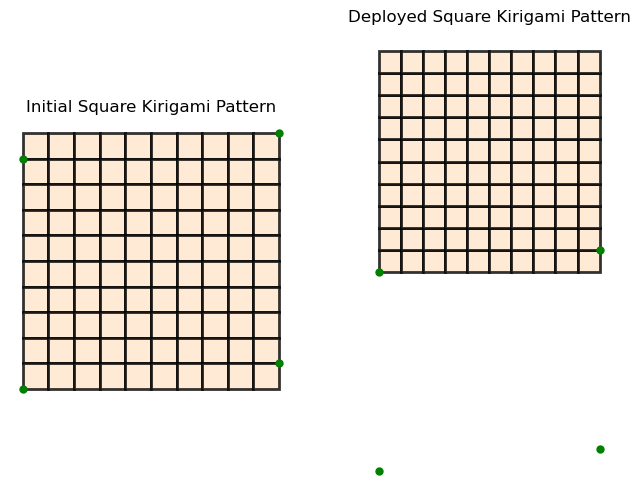

This Matrix is not invertible
Det: -7.089727956532931e+21


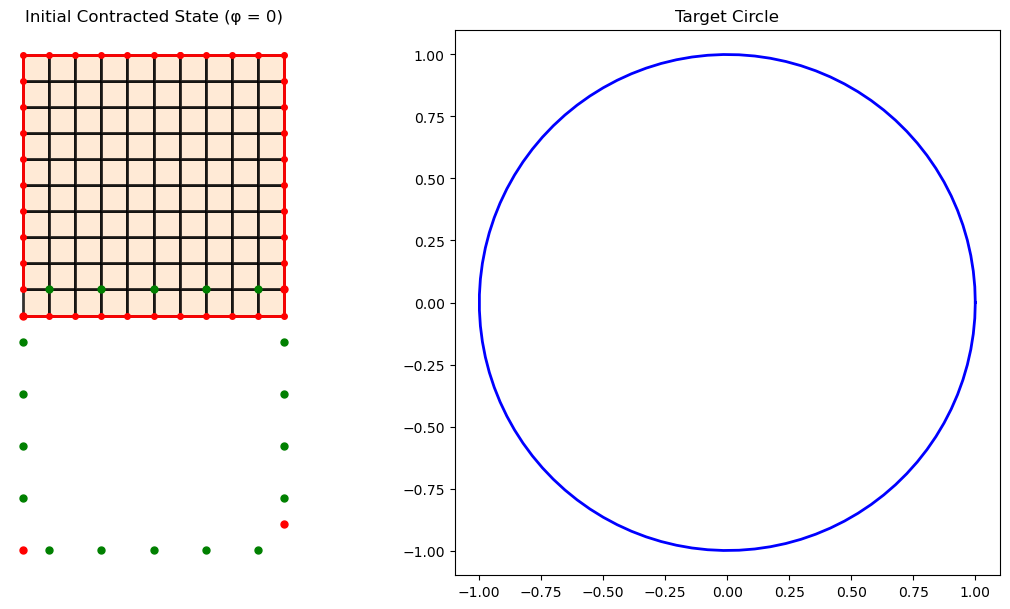

Optimization starts...
This Matrix is not invertible
Det: -7.089727956532931e+21
This Matrix is not invertible
Det: -7.089728004460781e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008937706e+21
This Matrix is not invertible
Det: -7.089728009209835e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009501308e+21
This Matrix is not invertible
Det: -7.089728009773588e+21
This Matrix is not invertible
Det: -7.089728010564534e+21
This Matrix is not invertible
Det: -7.089728014250261e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008274563e+21
This Matrix is not invertible
Det: -7.089728008844058e+21
This Matrix is not invertible
Det: -7.08972800915417e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009556873e+21
This Matrix is not invertible
Det: -7.089728009867

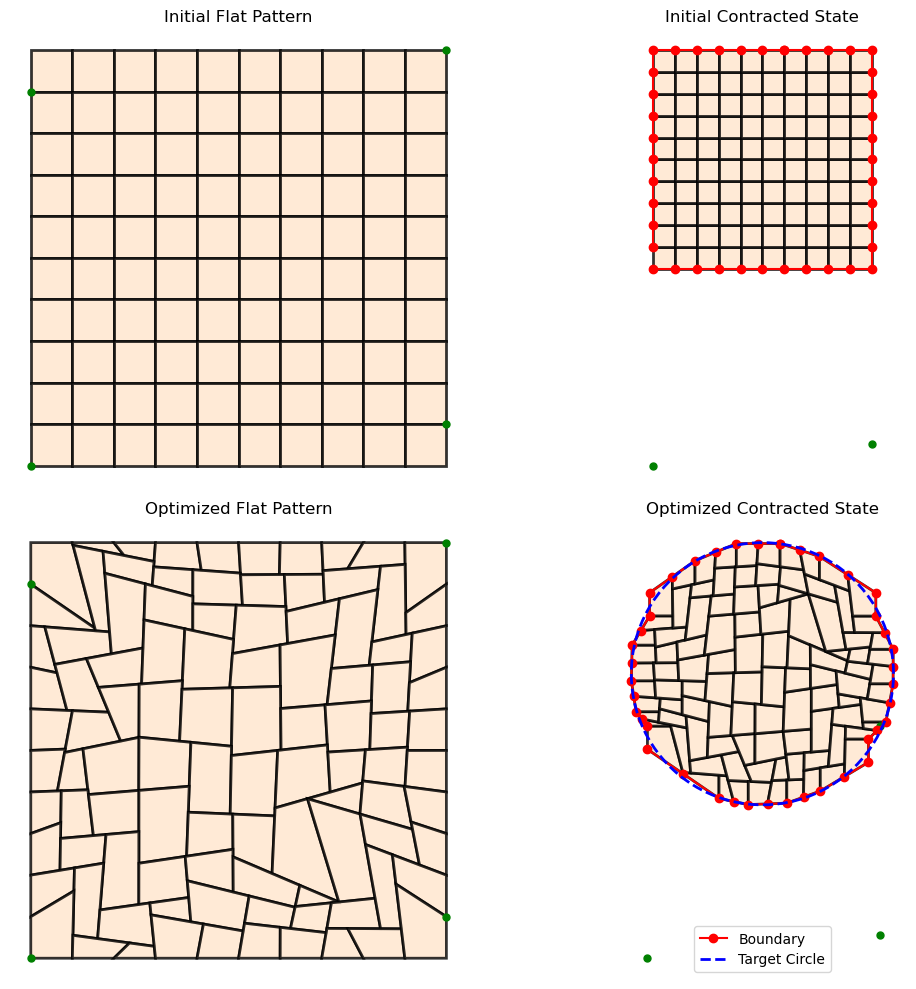

In [6]:
# set the pattern size
width = 9
height = 9

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

# Plot 1: Initial structure setup
fig, axs = plt.subplots(1, 2,figsize=(8, 6))
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
initial_points, _ = structure.layout(phi=np.pi)
plot_structure(initial_points, structure.quads, structure.linkages, axs[0])
# add corner points for reference
axs[0].plot(corners[:,0], corners[:,1], 'go', markersize=5)
axs[0].set_title("Initial Square Kirigami Pattern")
axs[0].set_aspect('equal')
initial_points2, _ = structure.layout(phi=0)
plot_structure(initial_points2, structure.quads, structure.linkages, axs[1])
# add corner points for reference
axs[1].plot(corners[:,0], corners[:,1], 'go', markersize=5)
axs[1].set_title("Deployed Square Kirigami Pattern")
axs[1].set_aspect('equal')
plt.show()



# also get the reconfigured boundary node indices for optimizing the second contracted shape
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)

# Plot 2: Initial contracted state and target circle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot initial contracted state
plot_structure(deployed_points, structure.quads, structure.linkages, ax1)
ax1.plot(corners[:,0], corners[:,1], 'ro', markersize=5)
# add boundary points for reference
for i, bound in enumerate(bound_linkage_inds):
    ax1.plot(boundary_points[i][:,0], boundary_points[i][:,1], 'go', markersize=5, label=f'Boundary {i+1}')
ax1.plot(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1], 'ro-', linewidth=2, markersize=4)
ax1.set_title("Initial Contracted State (φ = 0)")
ax1.set_aspect('equal')

# Plot target circle
theta = np.linspace(0, 2*np.pi, 100)
ax2.plot(np.cos(theta), np.sin(theta), 'b-', linewidth=2)
ax2.set_title("Target Circle")
ax2.set_aspect('equal')
plt.tight_layout()
plt.show()
        
# perform the nonlinear optimization to find an optimal set of offset parameters 
# that gives a square-to-circle transformation
print("Optimization starts...")
start = time.time()
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),bounds=(-np.ones(width*height),np.inf),xtol = 1e-8,verbose=2)
end = time.time()
print("Finished.")
print('Time taken = ' + str(end - start) + ' seconds')
print('Cost = ' + str(result.cost))

# Plot 3: Optimization results comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Initial flat pattern
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
initial_flat, _ = structure.layout(phi=np.pi)
plot_structure(initial_flat, structure.quads, structure.linkages, ax1)
# add corner points for reference
ax1.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax1.set_title("Initial Flat Pattern")
ax1.set_aspect('equal')

# Initial contracted
initial_contracted, _ = structure.layout(phi=0.0)
plot_structure(initial_contracted, structure.quads, structure.linkages, ax2)
# add corner points for reference
ax2.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax2.plot(initial_contracted[reduced_dual_bound_inds,0], initial_contracted[reduced_dual_bound_inds,1], 'ro-')
ax2.set_title("Initial Contracted State")
ax2.set_aspect('equal')

# Optimized flat pattern
opt_offsets = np.reshape(result.x, (height, width))
structure.linear_inverse_design(boundary_points_vector, corners, opt_offsets, boundary_offsets)
structure.make_hinge_contact_points()
opt_flat, _ = structure.layout(phi=np.pi)
plot_structure(opt_flat, structure.quads, structure.linkages, ax3)
ax3.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax3.set_title("Optimized Flat Pattern")
ax3.set_aspect('equal')

# Optimized contracted with circle overlay
opt_contracted, _ = structure.layout(phi=0.0)
plot_structure(opt_contracted, structure.quads, structure.linkages, ax4)
# add corner points for reference
ax4.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax4.plot(opt_contracted[reduced_dual_bound_inds,0], opt_contracted[reduced_dual_bound_inds,1], 'ro-', label='Boundary')
# Add target circle for comparison
center = np.mean(opt_contracted[reduced_dual_bound_inds], axis=0)
radius = np.mean(np.sqrt(np.sum((opt_contracted[reduced_dual_bound_inds] - center)**2, axis=1)))
theta = np.linspace(0, 2*np.pi, 100)
ax4.plot(center[0] + radius*np.cos(theta), center[1] + radius*np.sin(theta), 'b--', linewidth=2, label='Target Circle')
ax4.set_title("Optimized Contracted State")
ax4.set_aspect('equal')
ax4.legend()

plt.tight_layout()
plt.show()

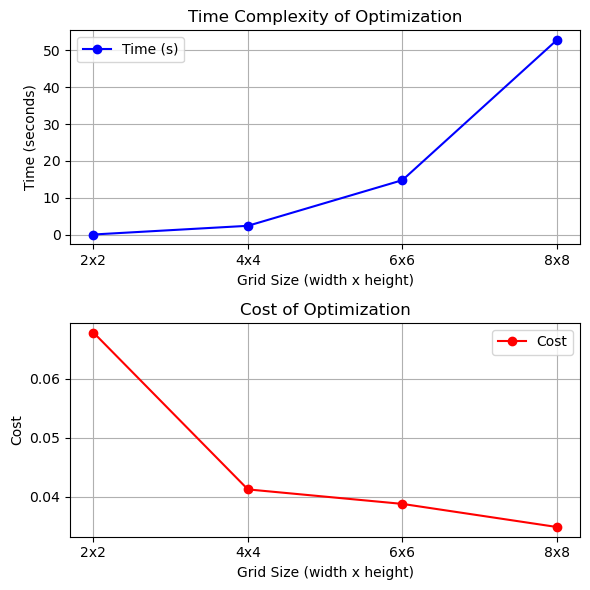

In [7]:
grid_sie = [2, 4, 6, 8]
times = [0.08072757720947266, 2.4358105659484863, 14.793537616729736, 52.73304080963135]
costs = [0.067798362921027, 0.041271954010370974, 0.038821522186830444, 0.03491407870806919]


# I want to have two subplots: one for time and one for cost
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 6))
# Plot time vs grid size
ax1.plot(grid_sie, times, marker='o', linestyle='-', color='b', label='Time (s)')
ax1.set_xlabel('Grid Size (width x height)')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Time Complexity of Optimization')
ax1.grid(True)
ax1.set_xticks(grid_sie)
ax1.set_xticklabels([f'{w}x{h}' for w, h in zip(grid_sie, grid_sie)])
ax1.legend() 
# Plot cost vs grid size
ax2.plot(grid_sie, costs, marker='o', linestyle='-', color='r', label='Cost')
ax2.set_xlabel('Grid Size (width x height)')
ax2.set_ylabel('Cost')
ax2.set_title('Cost of Optimization')
ax2.grid(True)
ax2.set_xticks(grid_sie)
ax2.set_xticklabels([f'{w}x{h}' for w, h in zip(grid_sie, grid_sie)])
ax2.legend()
plt.tight_layout()
plt.show()


## Plot the optimized pattern

This Matrix is not invertible
Det: -4.066312737278051e+22


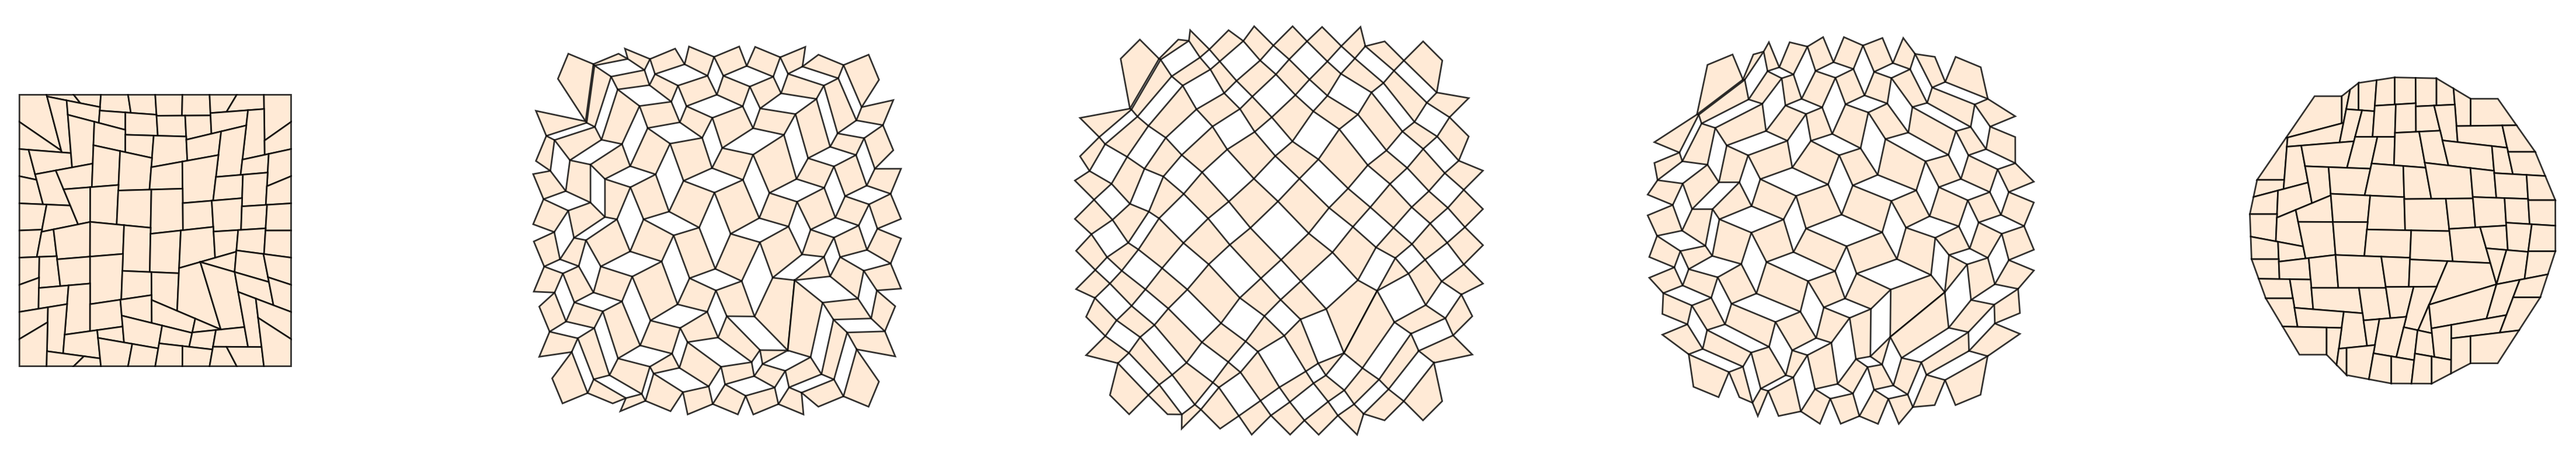

In [8]:
interior_offsets = np.reshape(result.x, (height,width)) # optimal offsets
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets, boundary_offsets)
structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

num_frames = 5
phis = np.linspace(np.pi, 0, num_frames)

panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    # add corner points for reference
    # axs[ax_ind].plot(corners[:,0], corners[:,1], 'ro', markersize=5)
    axs[ax_ind].set_aspect('equal')
    
#     write_obj('Example_square-to-circle_' + str(ax_ind) + '.obj', deployed_points, structure.quads)

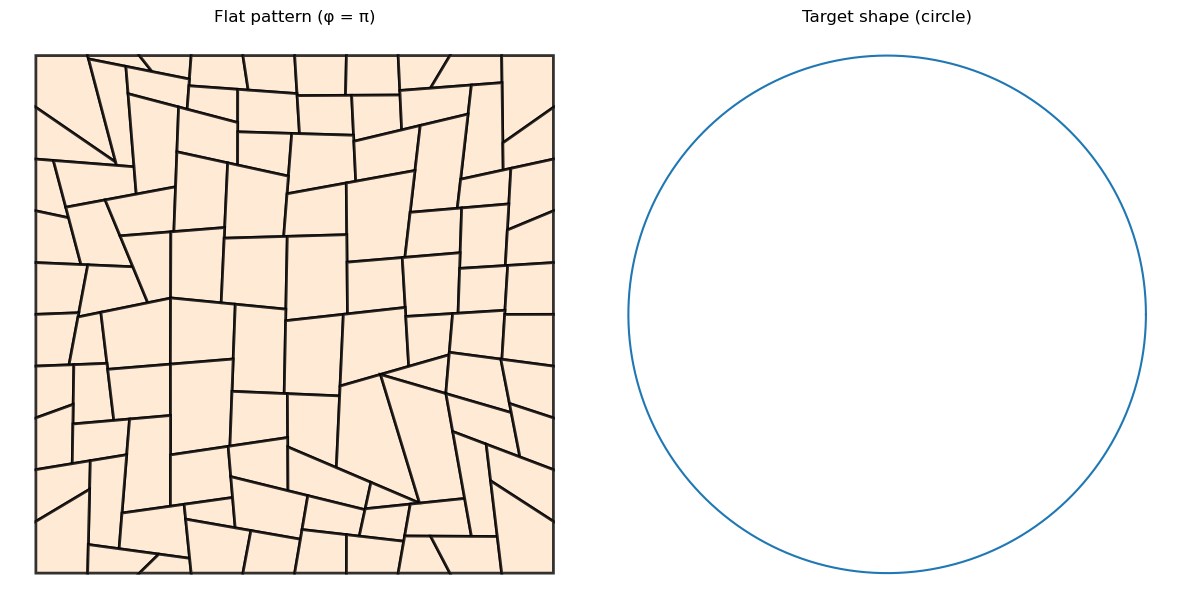

/tmp/ipykernel_2170978/2710853740.py:93: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))


Saved animation ➜ square_to_circle.gif


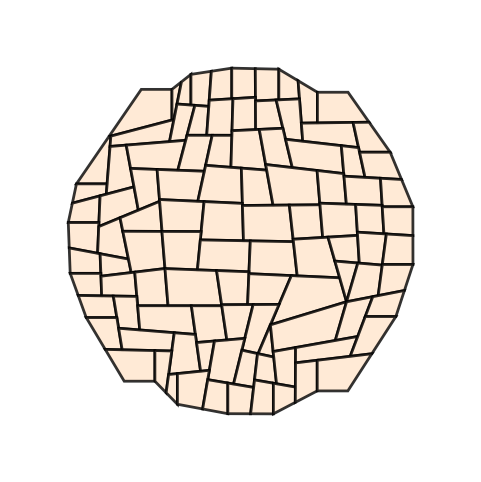

In [9]:

corners = corners
boundary_points_vector = boundary_points_vector
# %%
import matplotlib.pyplot as plt
from matplotlib import animation
import imageio
import os

# ---------- 1. Reference figure: target circle & undeployed pattern ----------
fig_ref, ax_ref = plt.subplots(1, 2, figsize=(12, 6))

# (left) undeployed pattern at phi = π
undeployed_pts, _ = structure.layout(phi=np.pi)
plot_structure(undeployed_pts, structure.quads, structure.linkages, ax_ref[0])
ax_ref[0].set_title("Flat pattern (φ = π)")
ax_ref[0].set_aspect('equal')
ax_ref[0].axis('off')

# (right) ideal target: unit circle
theta = np.linspace(0, 2*np.pi, 400)
ax_ref[1].plot(np.cos(theta), np.sin(theta))
ax_ref[1].set_title("Target shape (circle)")
ax_ref[1].set_aspect('equal')
ax_ref[1].axis('off')

plt.tight_layout()
plt.show()

# ---------- 2. Build animation frames ----------
num_frames = 40         # finer sweep for smoother animation
phis_anim = np.linspace(np.pi, 0, num_frames)

fig_anim, ax_anim = plt.subplots(figsize=(6, 6))
ax_anim.set_aspect('equal')
ax_anim.axis('off')

def init():
    ax_anim.clear()
    ax_anim.set_aspect('equal')
    ax_anim.axis('off')
    return []

def animate(i):
    phi = phis_anim[i]
    ax_anim.clear()
    ax_anim.set_aspect('equal')
    ax_anim.axis('off')

    pts, _ = structure.layout(phi)
    # recentre
    pts = rotate_points(pts, np.array([0, 0]), -(np.pi - phi)/2.0)
    pts[:,0] -= (pts[:,0].max() + pts[:,0].min())/2
    pts[:,1] -= (pts[:,1].max() + pts[:,1].min())/2

    plot_structure(pts, structure.quads, structure.linkages, ax_anim)
    # add corner points for reference
    # ax_anim.plot(corners[:,0], corners[:,1], 'ro', markersize=5)

    return []

ani = animation.FuncAnimation(fig_anim, animate, init_func=init,
                              frames=num_frames, interval=80, blit=True)

# ---------- 3. Save as GIF ----------
# First dump frames to PNGs (works reliably everywhere)
tmp_dir = "_tmp_frames"
os.makedirs(tmp_dir, exist_ok=True)
frame_files = []

# Determine global xlim and ylim for all frames
all_pts = []
for phi in phis_anim:
    pts, _ = structure.layout(phi)
    pts = rotate_points(pts, np.array([0, 0]), -(np.pi - phi)/2.0)
    pts[:,0] -= (pts[:,0].max() + pts[:,0].min())/2
    pts[:,1] -= (pts[:,1].max() + pts[:,1].min())/2
    all_pts.append(pts)
all_pts = np.vstack(all_pts)
xlim = (all_pts[:,0].min(), all_pts[:,0].max())
ylim = (all_pts[:,1].min(), all_pts[:,1].max())

for i in range(num_frames):
    animate(i)
    ax_anim.set_xlim(xlim)
    ax_anim.set_ylim(ylim)
    fname = os.path.join(tmp_dir, f"frame_{i:03d}.png")
    fig_anim.savefig(fname, bbox_inches="tight", pad_inches=0.05)
    frame_files.append(fname)

# stitch into GIF (6 fps → ~0.167 s per frame)
with imageio.get_writer("square_to_circle.gif", mode="I", duration=0.167, loop=0) as writer:
    for fname in frame_files:
        writer.append_data(imageio.imread(fname))

# clean up
for fname in frame_files:
    os.remove(fname)
os.rmdir(tmp_dir)

print("Saved animation ➜ square_to_circle.gif")



💓  Optimising for heart target …
This Matrix is not invertible
Det: -7.089727956532931e+21
This Matrix is not invertible
Det: -7.089728004460781e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008937706e+21
This Matrix is not invertible
Det: -7.089728009209835e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009501308e+21
This Matrix is not invertible
Det: -7.089728009773588e+21
This Matrix is not invertible
Det: -7.089728010564534e+21
This Matrix is not invertible
Det: -7.089728014250261e+21
This Matrix is not invertible
Det: -7.089728008146407e+21
This Matrix is not invertible
Det: -7.089728008274563e+21
This Matrix is not invertible
Det: -7.089728008844058e+21
This Matrix is not invertible
Det: -7.08972800915417e+21
This Matrix is not invertible
Det: -7.089728009355471e+21
This Matrix is not invertible
Det: -7.089728009556873e+21
This Matrix is not invertible
Det: -7.0

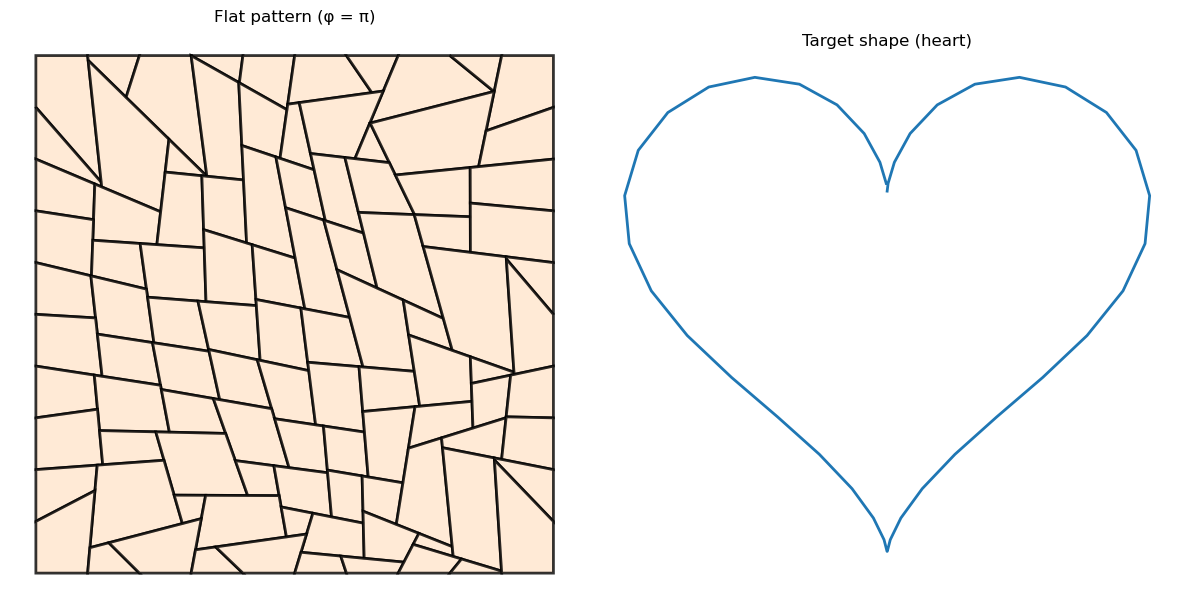

/tmp/ipykernel_2170978/532579058.py:125: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for fn in pngs: w.append_data(imageio.imread(fn))


✅  Saved ➜ square_to_heart.gif


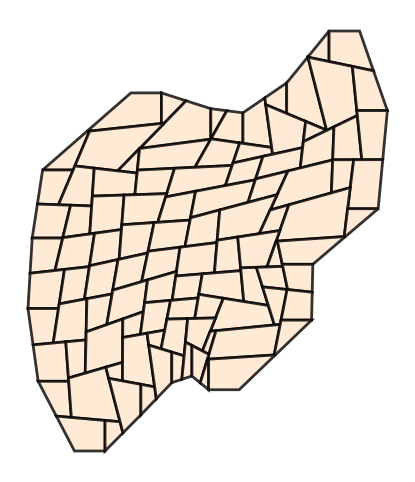

In [10]:
# %% [markdown]
# ## 🔄  Inverse design for a heart-shaped contraction + animation

# %%
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from matplotlib import animation
import imageio, os, shutil, time

# ------------------------------------------------------------------
# 1.  Target geometry: parametric heart curve,
#     re-sampled to match the number of dual-boundary vertices
# ------------------------------------------------------------------
num_target_pts = len(reduced_dual_bound_inds)
t = np.linspace(0, 2*np.pi, num_target_pts, endpoint=False)

# classical cardioid-like heart (scaled later)
x_heart = 16*np.sin(t)**3
y_heart = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)

target_points_raw = np.vstack([x_heart, y_heart]).T
# isotropically scale so its RMS radius is 1 (gives optimizer a sensible scale)
target_points_raw -= target_points_raw.mean(axis=0)
target_points_raw /= np.sqrt((target_points_raw**2).sum(axis=1)).mean()

# make it global so the residual can see it
target_points = target_points_raw.copy()           # <<< global

# ------------------------------------------------------------------
# 2.  Residual function: match every dual-boundary node to the target point
#     (up to a uniform scale and translation, which we strip out)
# ------------------------------------------------------------------
def boundary_residual_heart(interior_offsets_vector):
    global width, height, structure
    global boundary_points_vector, corners, boundary_offsets
    global reduced_dual_bound_inds, target_points
    
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # forward solve
    structure.linear_inverse_design(boundary_points_vector, corners,
                                    interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()
    deployed_pts, _ = structure.layout(phi=0.0)
    
    # extract, centre
    P = deployed_pts[reduced_dual_bound_inds]
    P -= P.mean(axis=0)
    T = target_points.copy()
    
    # best uniform scale (no rotation –  heart has clear orientation already)
    scale = np.linalg.norm(P) / np.linalg.norm(T)
    residuals = (P - scale*T).ravel()
    return residuals

# ------------------------------------------------------------------
# 3.  Optimise interior offsets
# ------------------------------------------------------------------
print("\n💓  Optimising for heart target …")
t0 = time.time()
result = scopt.least_squares(boundary_residual_heart,
                             x0=np.zeros(width*height),
                             bounds=(-np.ones(width*height), np.inf),
                             xtol=1e-4, verbose=2)
print(f"… done in {time.time()-t0:.1f}s, cost = {result.cost:.3e}")

# push optimal offsets back into structure for visualisation
opt_offsets = np.reshape(result.x, (height, width))
structure.linear_inverse_design(boundary_points_vector, corners,
                                opt_offsets, boundary_offsets)
structure.assign_node_layers(); structure.assign_quad_genders()
structure.make_hinge_contact_points()

# ------------------------------------------------------------------
# 4.  Plot reference figure: flat pattern & target heart
# ------------------------------------------------------------------
fig_ref, ax_ref = plt.subplots(1, 2, figsize=(12, 6))

# (left) undeployed pattern at φ = π
flat_pts, _ = structure.layout(phi=np.pi)
plot_structure(flat_pts, structure.quads, structure.linkages, ax_ref[0])
ax_ref[0].set_title("Flat pattern (φ = π)")
ax_ref[0].set_aspect("equal"); ax_ref[0].axis("off")

# (right) target heart
ax_ref[1].plot(target_points[:,0], target_points[:,1], linewidth=2)
ax_ref[1].set_title("Target shape (heart)")
ax_ref[1].set_aspect("equal"); ax_ref[1].axis("off")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# 5.  Build animation frames (flat ➜ heart) & save GIF
# ------------------------------------------------------------------
num_frames = 40
phis_anim = np.linspace(np.pi, 0, num_frames)

fig_anim, ax_anim = plt.subplots(figsize=(6, 6))
ax_anim.set_aspect("equal"); ax_anim.axis("off")

def draw_state(phi):
    ax_anim.clear(); ax_anim.set_aspect("equal"); ax_anim.axis("off")
    P, _ = structure.layout(phi)
    P = rotate_points(P, np.array([0, 0]), -(np.pi - phi)/2)
    P[:,0] -= (P[:,0].max()+P[:,0].min())/2
    P[:,1] -= (P[:,1].max()+P[:,1].min())/2
    plot_structure(P, structure.quads, structure.linkages, ax_anim)

def init(): draw_state(phis_anim[0]); return []
def animate(i): draw_state(phis_anim[i]); return []

ani = animation.FuncAnimation(fig_anim, animate, init_func=init,
                              frames=num_frames, interval=90, blit=True)

tmp_dir = "_tmp_frames_heart"
os.makedirs(tmp_dir, exist_ok=True)
pngs = []
for i, phi in enumerate(phis_anim):
    draw_state(phi)
    fn = os.path.join(tmp_dir, f"frame_{i:03d}.png")
    fig_anim.savefig(fn, bbox_inches="tight", pad_inches=0.0)
    pngs.append(fn)

with imageio.get_writer("square_to_heart.gif", mode="I", duration=0.15, loop=0) as w:
    for fn in pngs: w.append_data(imageio.imread(fn))

shutil.rmtree(tmp_dir)       # clean
print("✅  Saved ➜ square_to_heart.gif")

# %%
